# Features Description

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category
- This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import datetime as dt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,roc_auc_score,roc_curve
import datetime 

%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
df = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')

In [2]:
df = pd.read_csv('sales_train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sales_train.csv'

In [3]:
df.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [4]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df['date']= pd.to_datetime(df['date'])
df['item_cnt_day'] = df['item_cnt_day'].astype(int)

<AxesSubplot:>

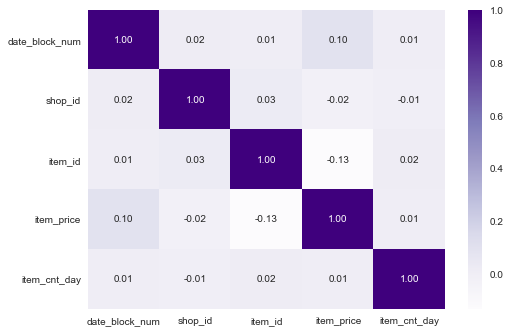

In [6]:
sns.heatmap(df.corr(), annot=True, fmt='0.2f', cmap='Purples')

In [9]:
df.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>],
       [<AxesSubplot:title={'center':'item_cnt_day'}>, <AxesSubplot:>]],
      dtype=object)

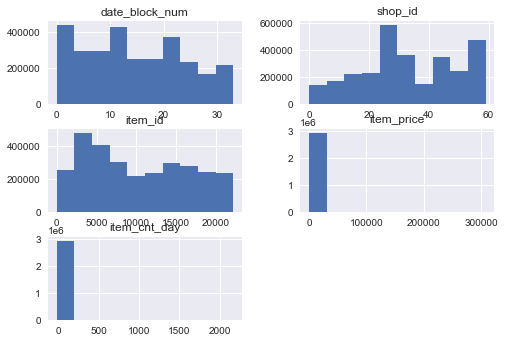

In [7]:
df.hist()

In [8]:
df0 = df[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']];df0.head(20)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1
1,0,25,2552,1
2,0,25,2552,-1
3,0,25,2554,1
4,0,25,2555,1
5,0,25,2564,1
6,0,25,2565,1
7,0,25,2572,1
8,0,25,2572,1
9,0,25,2573,3


In [9]:
df1 = df.drop(columns=['date'], axis=1)

In [10]:
df1.sort_values(by=['date_block_num'], ascending=False, inplace=True);df1.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935848,33,25,7460,299.0,1
2900207,33,57,11579,299.0,1
2900179,33,57,10529,169.0,1
2900178,33,57,10515,169.0,1
2900177,33,57,10894,199.0,1


In [40]:
df2 = df0.groupby([pd.Grouper(key='date_block_num'),'shop_id'])['item_cnt_day'].sum();df2.head(20)
df3 = df2.reset_index(drop=False)

,date_block_num,shop_id,item_cnt_day
0,0,0,5578
1,0,1,2947
2,0,2,1146
3,0,3,767
4,0,4,2114
5,0,6,3686
6,0,7,2495
7,0,8,1463
8,0,10,935
9,0,12,842


In [13]:
X, y = df3.drop(['item_cnt_day'], axis=1), df3['item_cnt_day']

In [15]:
def check_homoscedasticity(x, y, xlabel):
    plt.scatter(x, y, s=10, marker='+', c='green', alpha=0.5, label='student residuals')
    plt.axhline(0, c='red', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel('standard deviation')
    plt.legend()
    plt.show()

In [45]:
df3.groupby(by = 'shop_id').count()

,date_block_num,item_cnt_day
shop_id,,
0,2,2
1,2,2
2,34,34
3,34,34
4,34,34
5,33,33
6,34,34
7,34,34
8,4,4


In [48]:
df3 = df3[df3['shop_id'] == 2];df3.head(20)

,date_block_num,shop_id,item_cnt_day
2,0,2,1146
47,1,2,488
91,2,2,753
137,3,2,583
183,4,2,553
228,5,2,832
274,6,2,807
320,7,2,875
365,8,2,945
410,9,2,795


In [59]:
df3 = df2.reset_index(drop=False);df3.head(20)

,date_block_num,shop_id,item_cnt_day
0,0,0,5578
1,0,1,2947
2,0,2,1146
3,0,3,767
4,0,4,2114
5,0,6,3686
6,0,7,2495
7,0,8,1463
8,0,10,935
9,0,12,842


In [44]:
df3['shop_id'].count()

1586

In [60]:
max(df3['shop_id'])

59

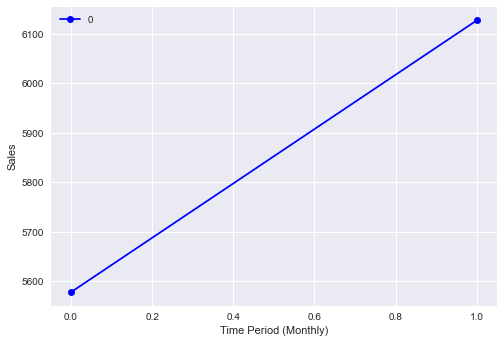

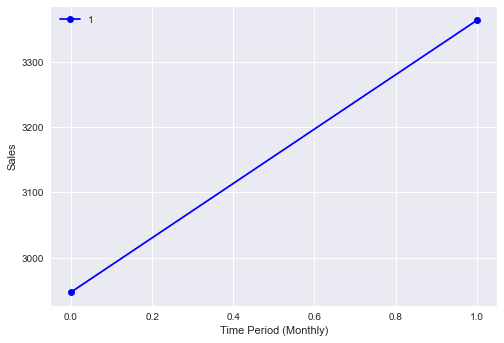

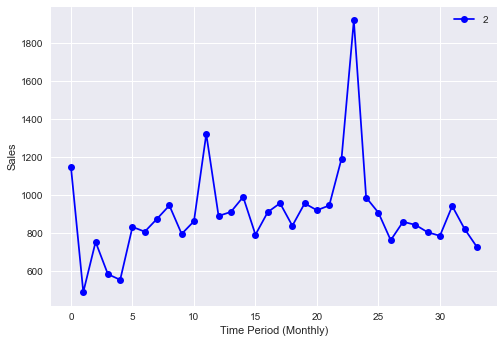

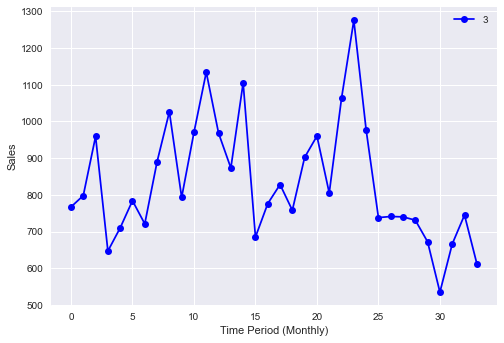

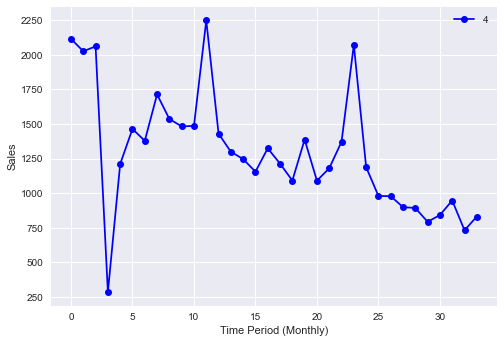

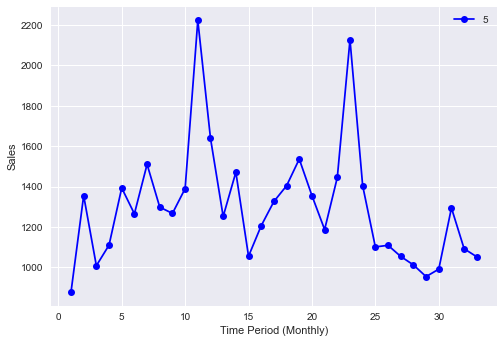

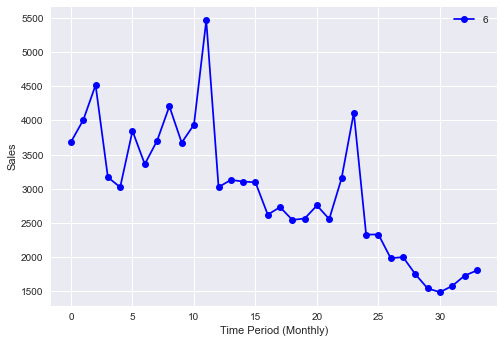

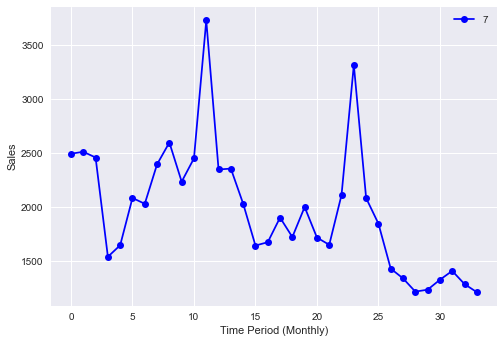

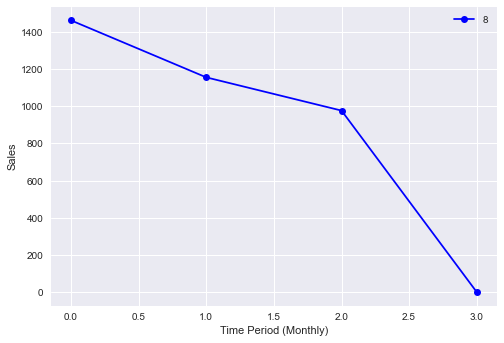

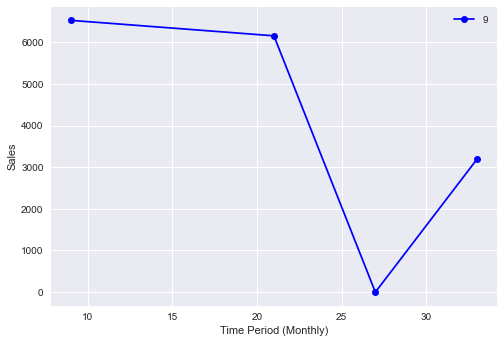

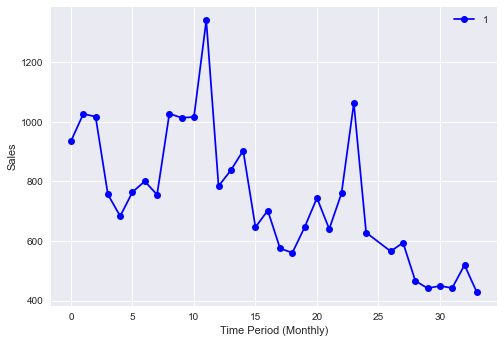

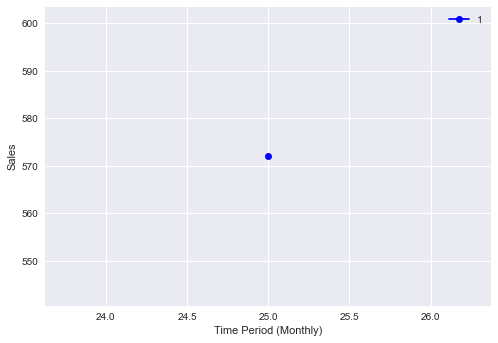

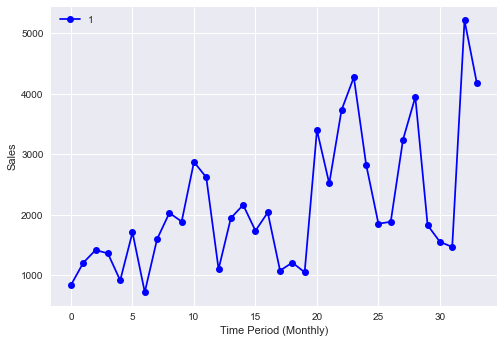

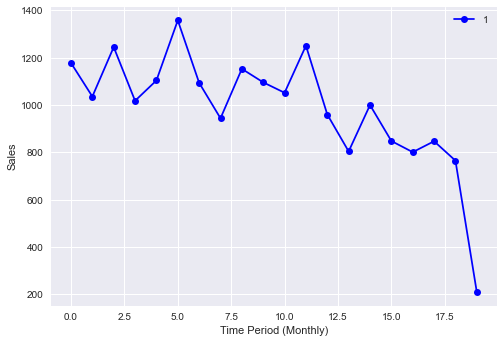

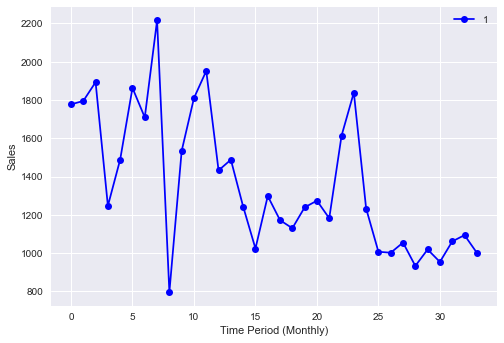

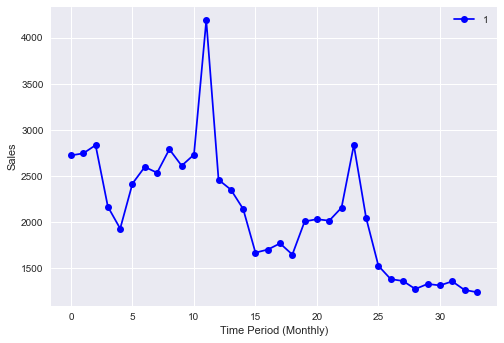

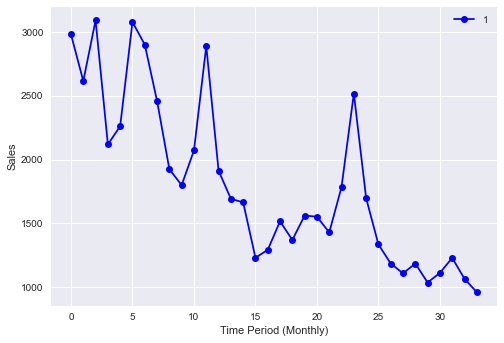

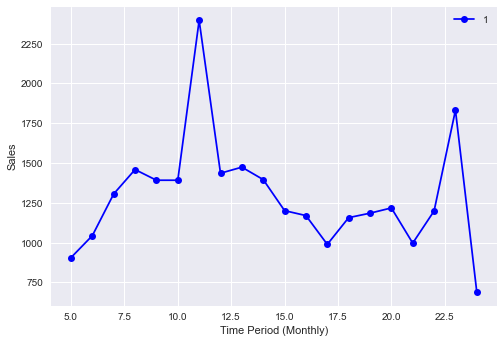

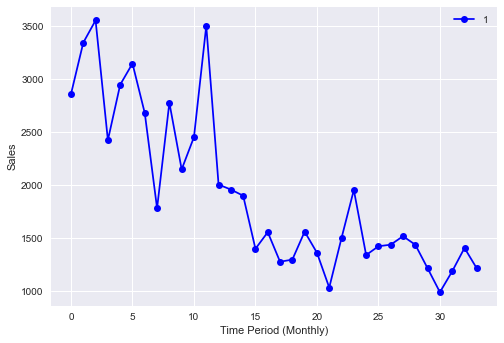

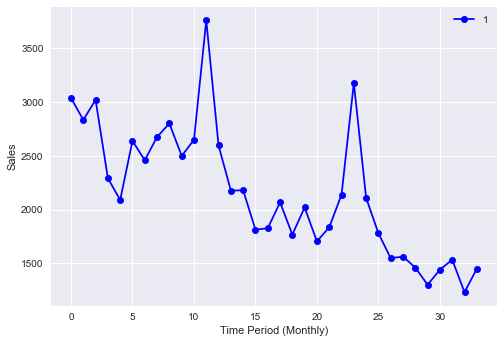

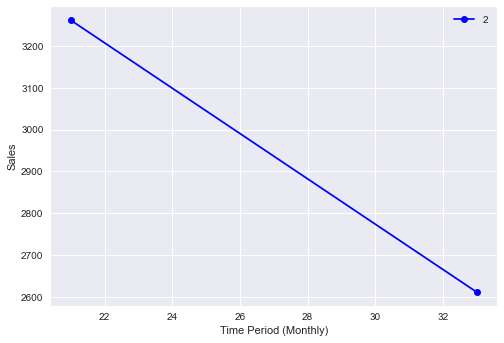

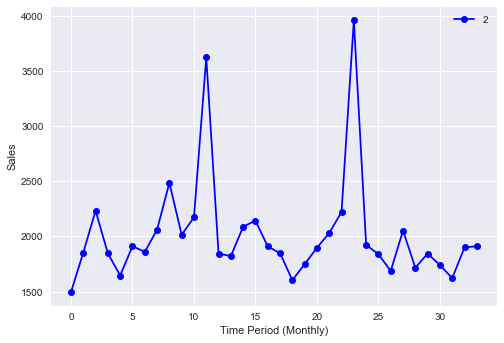

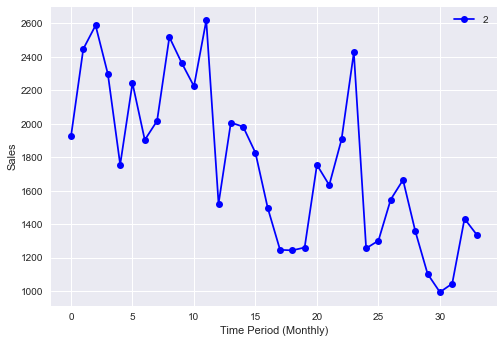

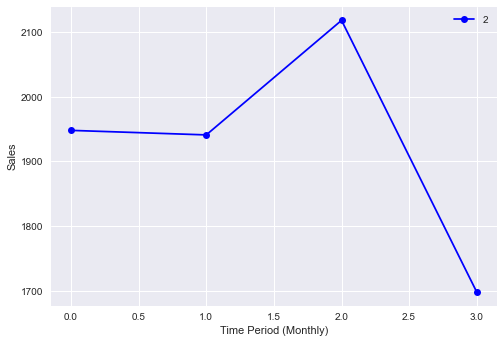

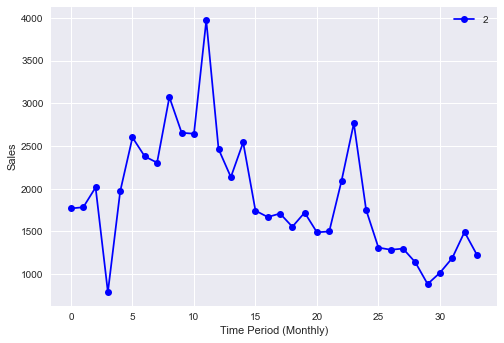

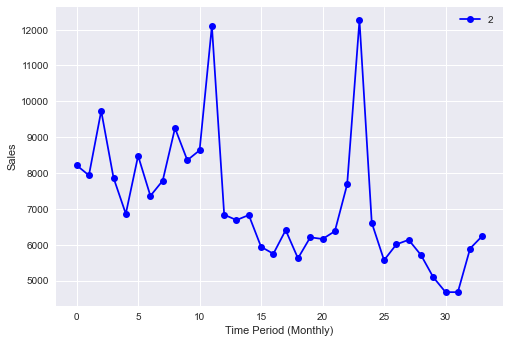

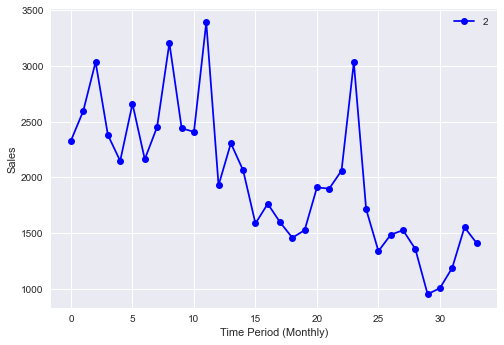

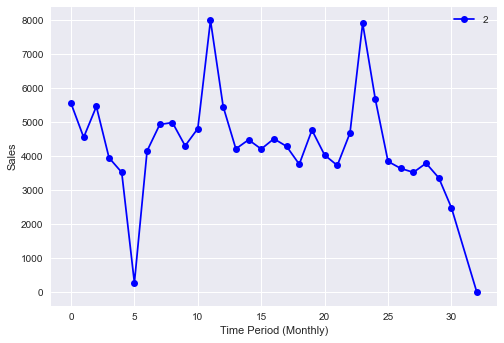

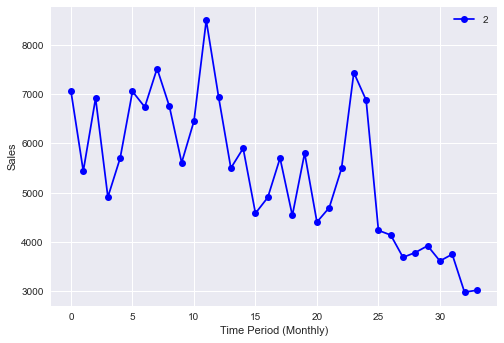

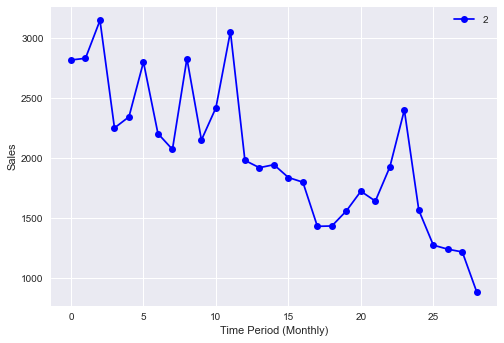

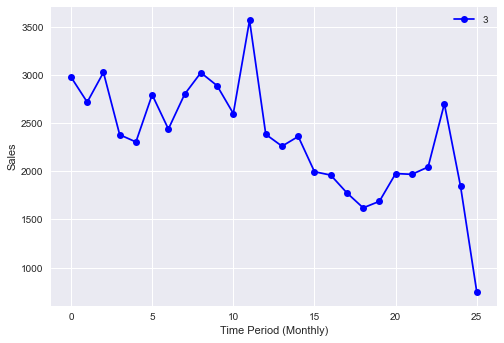

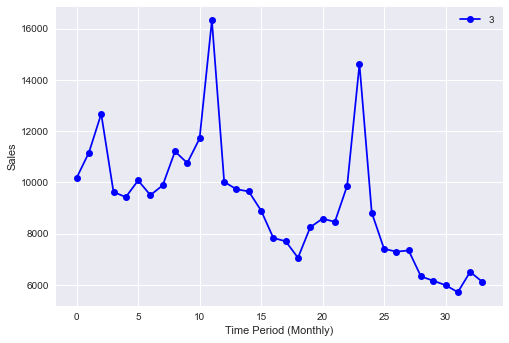

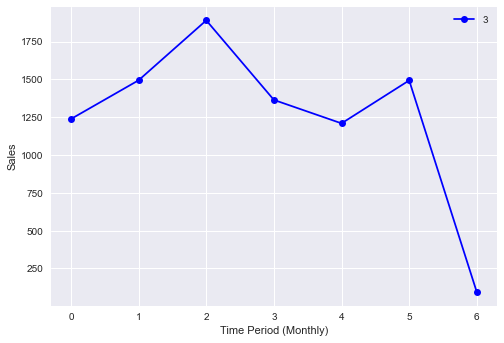

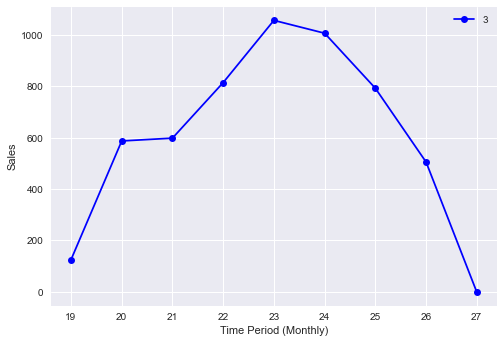

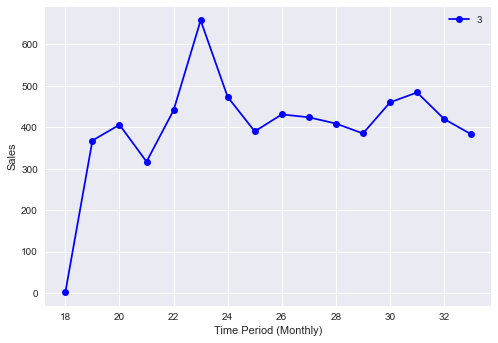

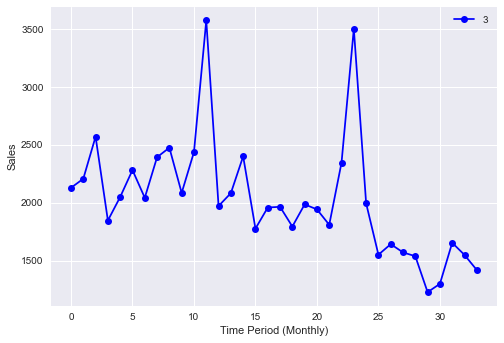

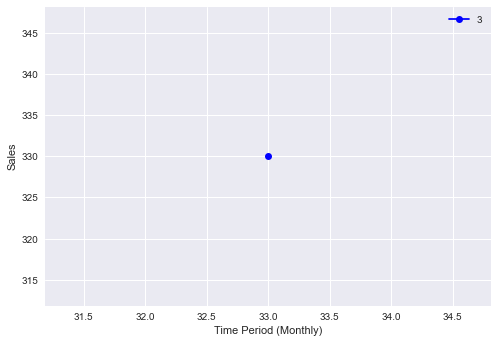

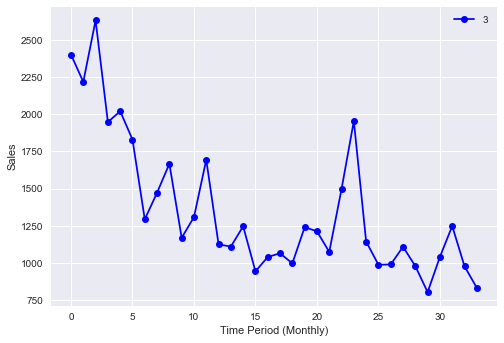

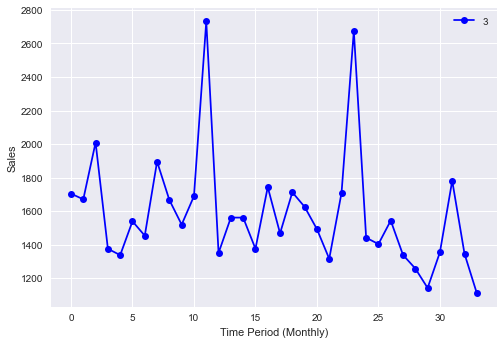

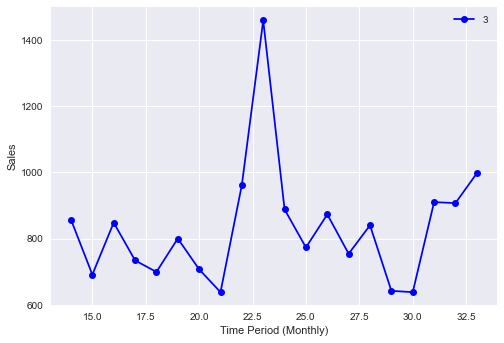

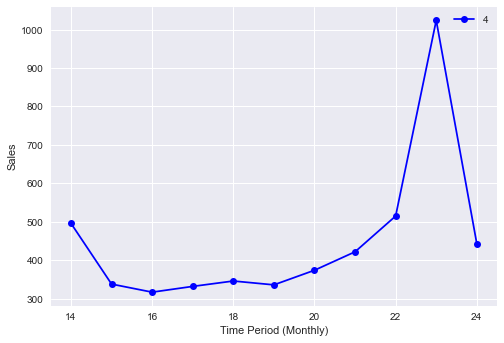

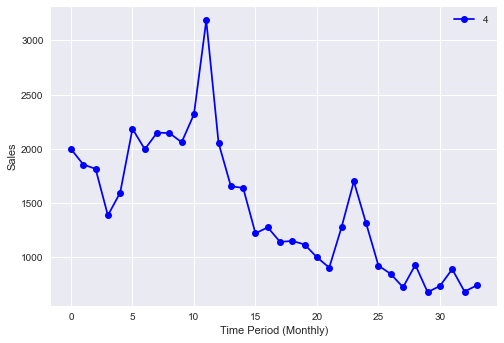

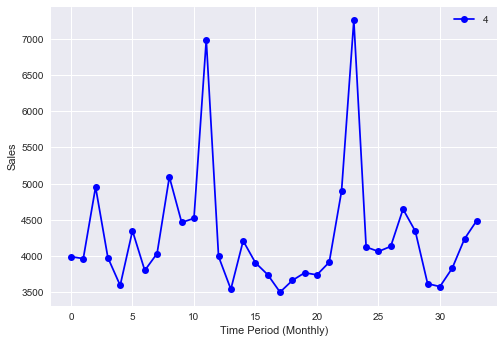

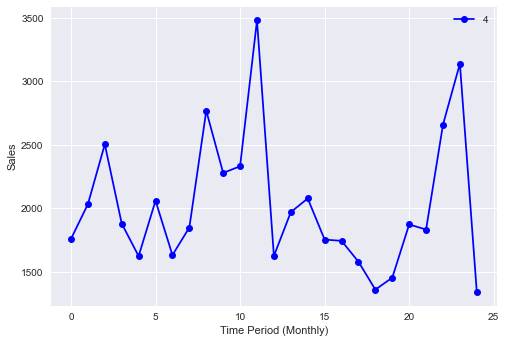

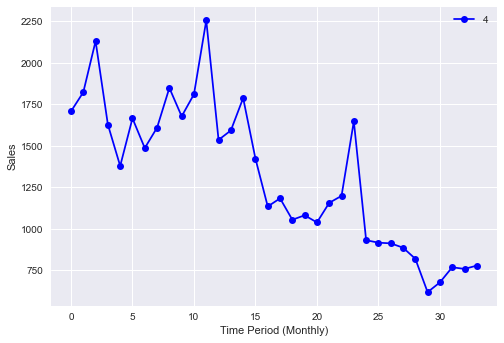

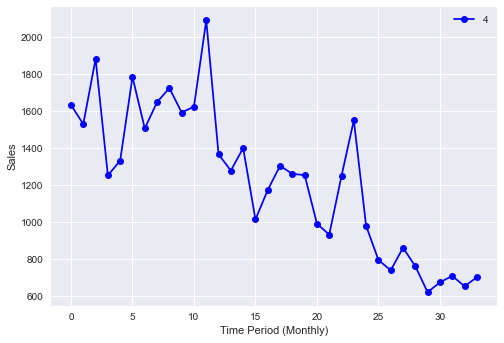

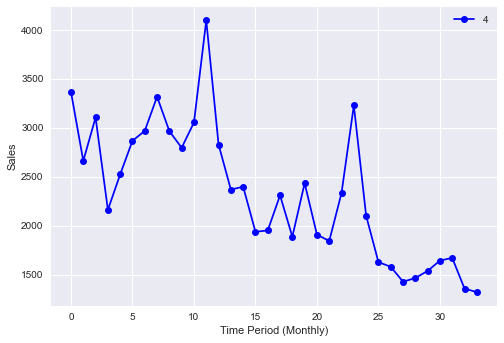

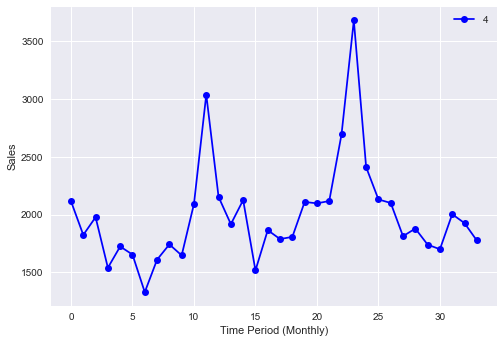

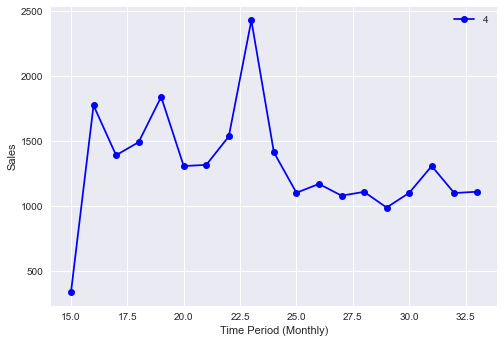

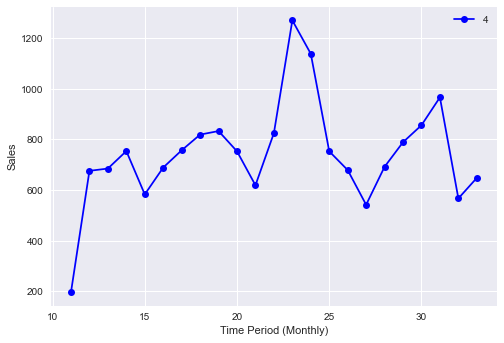

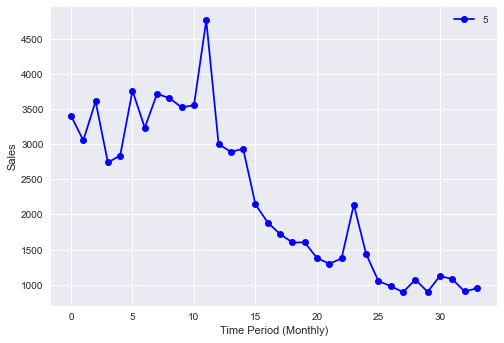

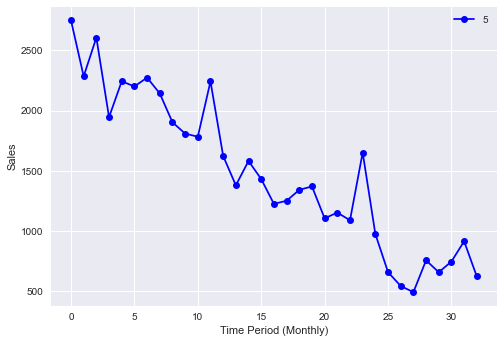

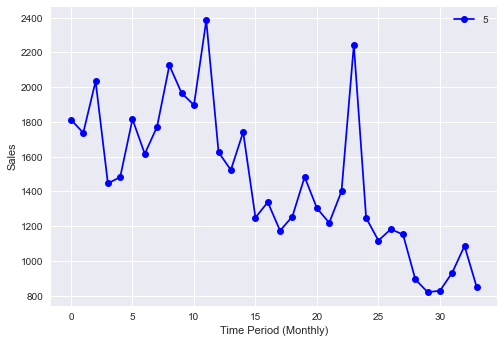

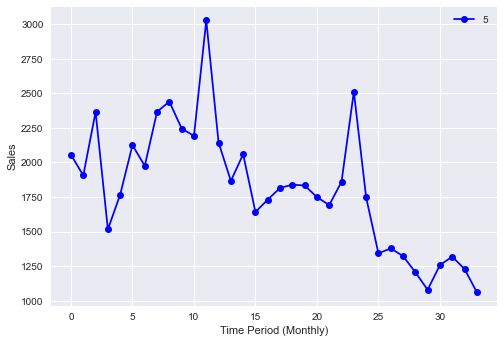

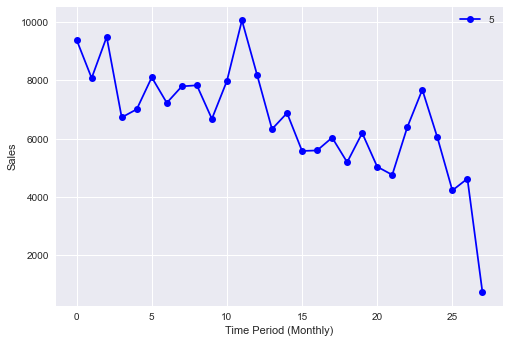

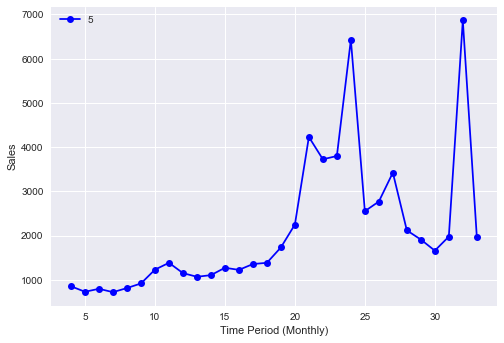

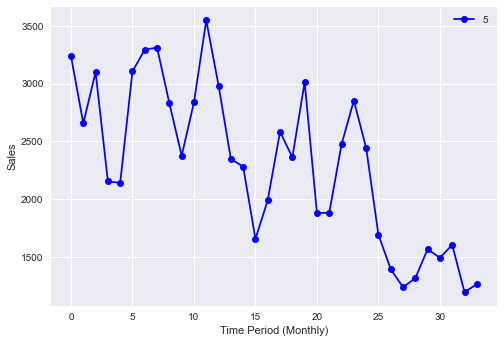

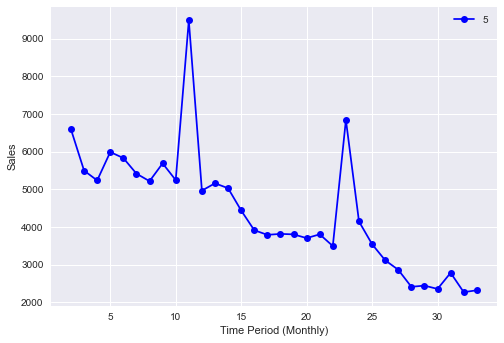

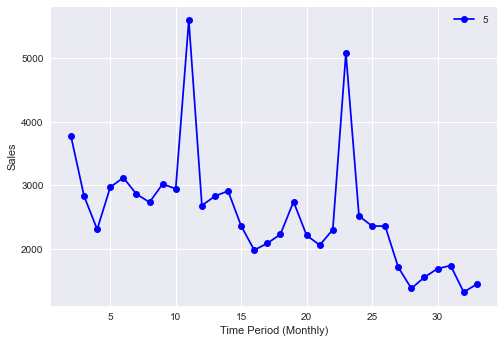

In [64]:
for i in range (0,59):

    df3 = df3[df3['shop_id'] == i]

    fig.suptitle('Total Sales by Month')

    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('Sales')
    actual = plt.plot(df3['date_block_num'], df3['item_cnt_day'], 'bo-', label='Sales')
    plt.legend(f'{i}')
    plt.show()
    
    df3 = df2.reset_index(drop=False)


In [18]:
check_homoscedasticity(X.shop_id, y.item_cnt_day, 'item_cnt_day')

AttributeError: 'Series' object has no attribute 'item_cnt_day'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [17]:
# 16. Run all the other classifiers that we have learned so far in class
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict), \
           recall_score(y_test, y_predict)

print("\n16. Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestRegressor, X_train, X_test, y_train, y_test))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Decision Tree:", get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test))
print("    Naive Bayes:", get_scores(MultinomialNB, X_train, X_test, y_train, y_test))
print("    Gradient:", get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test))


16. Model, Accuracy, Precision, Recall


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets